In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
import seaborn as sns
from models.modules import Seq2Seq, Encoder, Decoder, PositionalEncoding
import torch.nn as nn
import time
warnings.filterwarnings("ignore")
from dataset.dataset import ChatDataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
special_tokens_dict = {'additional_special_tokens': ['[SOS]','[EOS]']}
tokenizer.add_special_tokens(special_tokens_dict)
VOCAB_SIZE = tokenizer.vocab.keys()

/home/xps/anaconda3/envs/deeplearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/xps/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
x = torch.rand(32, 32, 30)
d_model = 30
scale = 10000

PE = torch.zeros(x.shape[1], x.shape[2])
for i in range(PE.shape[0]):
    for j in range(PE.shape[1]):
        if j % 2 == 0:
            PE[i, j] += math.sin(i/scale**(j/d_model))
        else:
            PE[i, j] += math.cos(i/scale**(j-1/d_model))


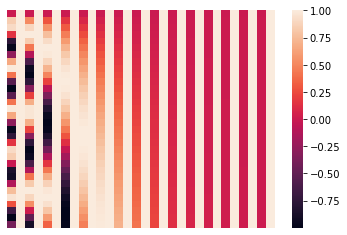

In [3]:
fig, ax = plt.subplots()
ax.axis(False)
sns.heatmap(PE)
plt.show()

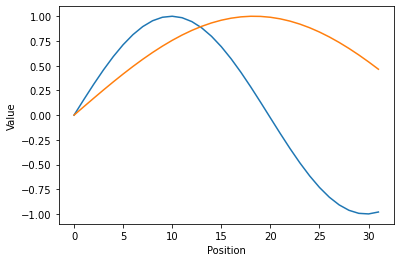

In [4]:
fig, ax = plt.subplots()
ax.plot(PE[:, [6, 8]]) #sin(pos/10000^(dim/d_model))
ax.set_xlabel("Position")
ax.set_ylabel("Value")
ax.set_label("The wavelengths of different dimension") #2pi to 10000 2pi as dimension increase
ax.axis(True)
sns.set()
plt.show()

In [8]:
encoder = Encoder(n_seq=5, d_model=512, d_ff=2048, h=8, N=6, p_drop=0.1, label_smoothing=None)
decoder = Decoder(n_seq=5, d_model=512, d_ff=2048, h=8, N=6, p_drop=0.1, label_smoothing=None)
seq2seq = Seq2Seq(encoder, decoder)


MASK ??? tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
MASK ??? tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
MASK ??? tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
MASK ??? tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
MASK ??? tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
MASK ??? tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


In [10]:
x = torch.tensor([0, 1, 2, 3, 4], dtype=torch.long).unsqueeze(0)
y = torch.tensor([0, 1, 2, 3, 4], dtype=torch.long).unsqueeze(0)

In [11]:
start = time.time()
out = seq2seq(x, y)[0]
out.mean(), time.time() - start

(tensor(0.0053, grad_fn=<MeanBackward0>), 0.13312959671020508)

<AxesSubplot:>

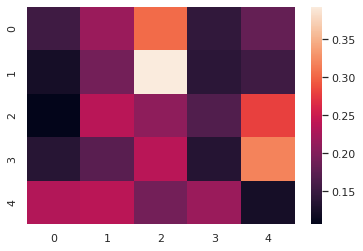

In [15]:
#attention weights of the encoder (no mask)
encoder = seq2seq.encoder
sns.heatmap(encoder.attention_weights['attention'][0].detach().numpy()[0, :, :])

<AxesSubplot:>

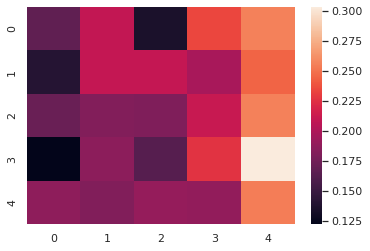

In [14]:
#attention weights of decoder
decoder = seq2seq.decoder
weight = decoder.attention_weights['attention'][0].detach().numpy()[0]
sns.heatmap(weight)

In [43]:
#compare with nn implementation
start = time.time()
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = nn.Embedding(5, 512)(x)
src = PositionalEncoding('direct', scale=10000, p_drop=0.1, x=src, d_model=512)
out = transformer_encoder(src)
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
tgt = nn.Embedding(5, 512)(y)
tgt = PositionalEncoding('direct', scale=10000, p_drop=0.1, x=tgt, d_model=512)
memory = out
out = transformer_decoder(tgt, memory)
out.mean(), time.time() - start

(tensor(5.9605e-09, grad_fn=<MeanBackward0>), 0.27057504653930664)

In [2]:
#tokenizer
PATH = "/home/xps/projects/deep-learning-/NLP/implement/temp/data/raw"
data = pd.read_csv(os.path.join(PATH, 'cornell movie-dialogs corpus/pair_df.csv'), sep='@')
dataset = ChatDataset(data, MAX_LEN=20)

In [4]:
dataset[33][0].shape

torch.Size([20])